In [1]:
import os
import numpy as np 
import cv2
import matplotlib.pyplot as plt 
import exiftool
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')

https://micasense.github.io/imageprocessing/MicaSense%20Image%20Processing%20Tutorial%201.html
https://micasense.github.io/imageprocessing/MicaSense%20Image%20Processing%20Setup.html
https://github.com/micasense/imageprocessing/blob/master/micasense/utils.py

## Raw to Radiance

In [4]:
os.chdir('/mnt/c/DATA/PhG/Micasense/000/')

In [5]:
my_file = 'IMG_0002_3.tif'

In [6]:
def read_image(file):
    files = [file]
    with exiftool.ExifTool() as et:
        metadata = et.get_metadata_batch(files)
    meta = metadata[0]
    imageRaw = cv2.imread(files[0], -1)
    return (imageRaw, meta)    

In [7]:
def vignette_map(meta):
    # get vignette center
    xVignette = float(meta['XMP:VignettingCenter'][0])
    yVignette = float(meta['XMP:VignettingCenter'][1])

    # get vignette polynomial
    vignettePolyList = [float(i) for i in meta['XMP:VignettingPolynomial']]

    # reverse list and append 1., so that we can call with numpy polyval
    vignettePolyList.reverse()
    vignettePolyList.append(1.)
    vignettePoly = np.array(vignettePolyList)

    # perform vignette correction
    # get coordinate grid across image
    xDim, yDim = meta['EXIF:ImageWidth'],meta['EXIF:ImageHeight']
    x, y = np.meshgrid(np.arange(xDim), np.arange(yDim))

    # meshgrid returns transposed arrays
#     x = x.T
#     y = y.T

    # compute matrix of distances from image center
    r = np.hypot((x - xVignette), (y - yVignette))

    # compute the vignette polynomial for each distance - we divide by the polynomial so that the
    # corrected image is image_corrected = image_original * vignetteCorrection
    vignette = 1. / np.polyval(vignettePoly, r)
    return vignette, x, y

In [8]:
def raw_to_radiance(imageRaw, meta):
    
    # First, we get the darkPixel values.
    blackLevel = meta['EXIF:BlackLevel']
    blackLevel = np.array([int(item) for item in blackLevel.split(' ')])
    darkLevel = blackLevel.mean()
    
    # Get the imager-specific calibrations
    a1, a2, a3 = [float(i) for i in meta['XMP:RadiometricCalibration']]
    
    # Get the parameters of the optical chain (vignette) effects and create a vignette map
    V, x, y = vignette_map(meta)
    
    #we get the exposure and gain settings (gain is represented in the photographic parameter ISO, with a base ISO of 100, so we divide the result to get a numeric gain)    
    exposureTime = float(meta['EXIF:ExposureTime'])
    gain = float(meta['EXIF:ISOSpeed'])/100.0
    
    # Calculate the imager-specfic radiometric correction function, which help to account for the radiometric inaccuracies of the CMOS imager pixels
    R = 1.0 / (1.0 + a2 * y / exposureTime - a3 * y)
    #subtract the dark level and adjust for vignette and row gradient
    L = V * R * (imageRaw - darkLevel)
    
    # apply the radiometric calibration - 
    # scale by the gain-exposure product and multiply with the radiometric calibration coefficient
    bitsPerPixel = meta['EXIF:BitsPerSample']
    dnMax = float(2**bitsPerPixel)
    radianceImage = L.astype(float)/(gain * exposureTime)*a1/dnMax
    return (radianceImage)

In [11]:
cv2.imread('C:/DATA/PhG/Micasense/000/IMG_0002_3.tif', -1)

In [13]:
my_image,  my_meta = read_image(my_file)

In [14]:
my_calibrated_image = raw_to_radiance(my_image, my_meta)

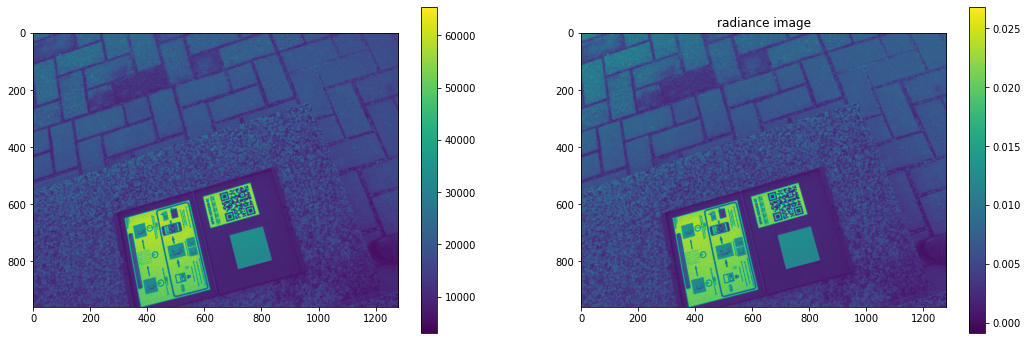

In [15]:
plt.figure(figsize = (18,6))
plt.title('raw image')
plt.subplot(1,2,1)
plt.imshow(my_image)
plt.colorbar()
plt.subplot(1,2,2)
plt.title('radiance image')
plt.imshow(my_calibrated_image)
plt.colorbar()

## Read Metadata

In [16]:
my_image, my_meta = read_image(my_file)

In [17]:
print('Channel\t\t{} \nWavelength\t{}\nBandHalfWidth\t{}'.format(my_meta['XMP:BandName'],
                                                           my_meta['XMP:CentralWavelength'],
                                                           my_meta['XMP:WavelengthFWHM']))

Channel		Red 
Wavelength	668
BandHalfWidth	10


In [18]:
channel_min = my_meta['XMP:CentralWavelength'] - my_meta['XMP:WavelengthFWHM']/2
channel_max = my_meta['XMP:CentralWavelength'] + my_meta['XMP:WavelengthFWHM']/2

## Caibrate Radiance

In [19]:
#read panel reflectance
panel_reflectance = pd.read_csv('/mnt/c/DATA/PhG/Micasense/RP04-1826268-SC.csv', names = ['nm', 'refl'])

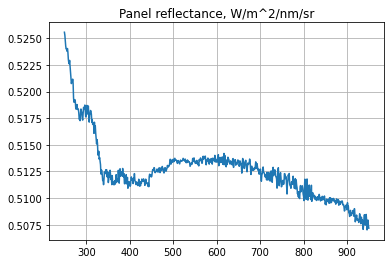

In [20]:
plt.title('Panel reflectance, W/m^2/nm/sr')
plt.plot(panel_reflectance.nm, panel_reflectance.refl)
# plt.axvline(channel_min, color = 'red')
# plt.axvline(channel_max, color = 'red')
plt.grid()

In [28]:
def get_calibration_factor(panelImage, panelRectangle = [725,775, 725,800],
                            panel_reflectance_file = '/mnt/c/DATA/PhG/Micasense/RP04-1826268-SC.csv'):
    
    rawImage,  metaData = read_image(panelImage)
    panelRadiance = raw_to_radiance(rawImage, metaData)
    
    print('Channel\t\t{} \nWavelength\t{}\nBandHalfWidth\t{}'.format(metaData['XMP:BandName'],
                                                                     metaData['XMP:CentralWavelength'],
                                                                     metaData['XMP:WavelengthFWHM']))
    
    channel_min = my_meta['XMP:CentralWavelength'] - my_meta['XMP:WavelengthFWHM']/2
    channel_max = my_meta['XMP:CentralWavelength'] + my_meta['XMP:WavelengthFWHM']/2
    panelReflectance = panel_reflectance.loc[(panel_reflectance.nm>=channel_min)&(panel_reflectance.nm<=channel_max)].refl.mean()
    
    
    panelRegion = panelRadiance[725:775, 725:800]
    meanRadiance = panelRegion.mean()
    print('Mean Radiance in panel region: {:1.3f} W/m^2/nm/sr'.format(meanRadiance))
    reflectanceScaleFacor = panelReflectance / meanRadiance
    print('Radiance conversion factor: {:1.3f}'.format(reflectanceScaleFacor))
    
    return(reflectanceScaleFacor)
    
    

In [29]:
get_calibration_factor('IMG_0002_1.tif')

Channel		Blue 
Wavelength	475
BandHalfWidth	20
Mean Radiance in panel region: 0.004 W/m^2/nm/sr
Radiance conversion factor: 114.553


114.55338227040964

In [30]:
get_calibration_factor('IMG_0002_2.tif')

Channel		Green 
Wavelength	560
BandHalfWidth	20
Mean Radiance in panel region: 0.014 W/m^2/nm/sr
Radiance conversion factor: 37.424


37.42431677328727

In [31]:
get_calibration_factor('IMG_0002_3.tif')

Channel		Red 
Wavelength	668
BandHalfWidth	10
Mean Radiance in panel region: 0.012 W/m^2/nm/sr
Radiance conversion factor: 42.001


42.00063407232873

In [32]:
get_calibration_factor('IMG_0002_4.tif')

Channel		NIR 
Wavelength	840
BandHalfWidth	40
Mean Radiance in panel region: 0.008 W/m^2/nm/sr
Radiance conversion factor: 62.594


62.593980888418855

In [33]:
get_calibration_factor('IMG_0002_5.tif')

Channel		Red edge 
Wavelength	717
BandHalfWidth	10
Mean Radiance in panel region: 0.010 W/m^2/nm/sr
Radiance conversion factor: 51.853


51.85315256569347

## Calibrate image by panel Photo

In [35]:
blue = 'IMG_0001_1.tif'
green = 'IMG_0001_2.tif'
red = 'IMG_0001_3.tif'
nir = 'IMG_0001_4.tif'
rededge = 'IMG_0001_5.tif'

In [36]:
blue_image,  blue_meta = read_image(blue)
blue_calibrated = raw_to_radiance(blue_image, blue_meta)*114.55338227040964

In [37]:
green_image,  green_meta = read_image(green)
green_calibrated = raw_to_radiance(green_image, green_meta)*37.42431677328727

In [38]:
red_image,  red_meta = read_image(red)
red_calibrated = raw_to_radiance(red_image, red_meta)*42.00063407232873

In [39]:
nir_image,  nir_meta = read_image(nir)
nir_calibrated = raw_to_radiance(nir_image, nir_meta)*62.593980888418855

In [40]:
rededge_image,  rededge_meta = read_image(rededge)
rededge_calibrated = raw_to_radiance(rededge_image, rededge_meta)*51.85315256569347

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


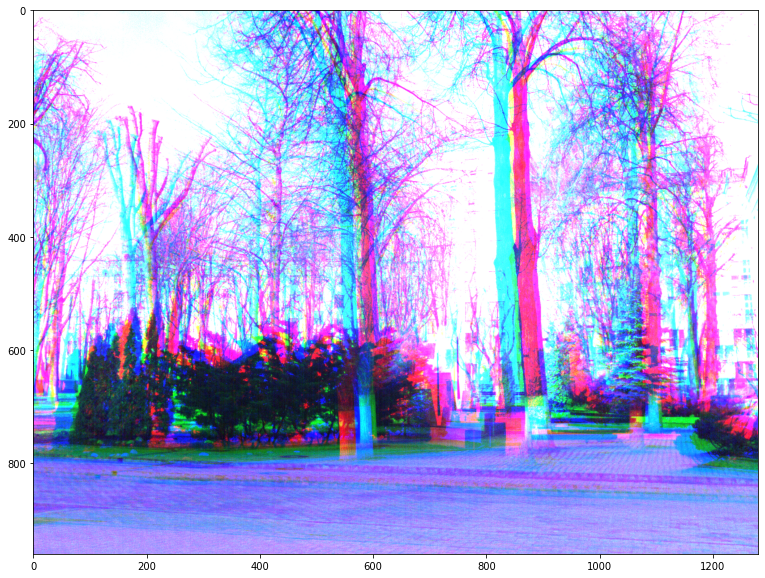

In [41]:
rgb_stack = np.stack((red_calibrated, green_calibrated,  blue_calibrated), axis = 2)
plt.figure(figsize=(25, 10))
plt.imshow(rgb_stack)
plt.show()

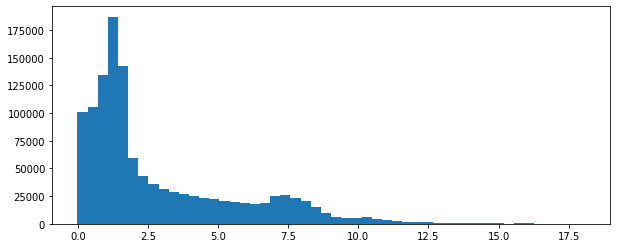

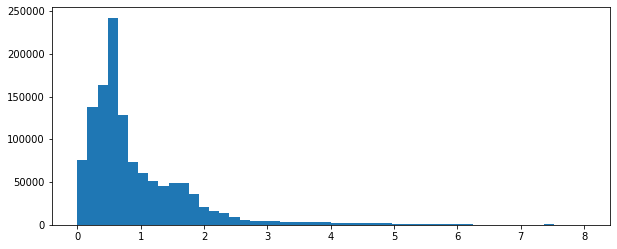

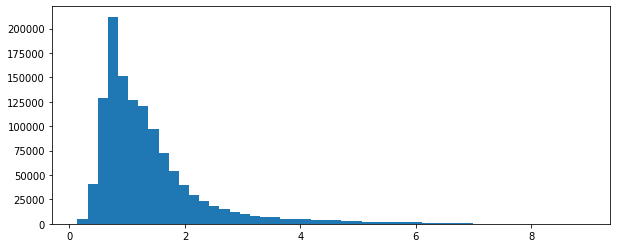

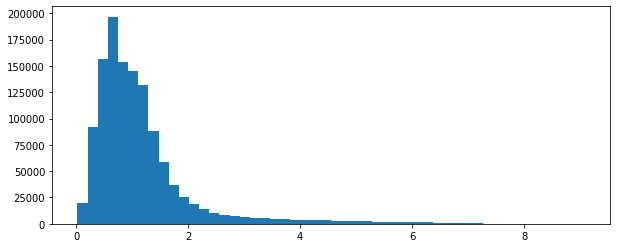

In [42]:
for image in [blue_calibrated, green_calibrated, nir_calibrated, rededge_calibrated]:
    plt.figure(figsize=(10, 4))
    plt.hist(image.ravel(), bins = 50)
    plt.show()

In [43]:
red_calibrated.dtype

dtype('float64')

## SHIFT

In [44]:
def shift_image(base_image, warp_image, n_iter = 10**3, inc = 1e-20):
    base_image = base_image.astype(np.float32)
    warp_image = warp_image.astype(np.float32)
    sz = base_image.shape
    
    # Define the motion model
    warp_mode = cv2.MOTION_TRANSLATION
    
    # Define matrice and initialize the matrix to identity
    warp_matrix = np.eye(2, 3, dtype=np.float32)
    
    #Specify the number of iterations
    number_of_iterations = n_iter
    
    # Specify the threshold of the increment in the correlation coefficient between two iterations
    termination_eps = inc
    
    # Define termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
    
    # Run the ECC algorithm. The results are stored in warp_matrix
    (cc, warp_matrix) = cv2.findTransformECC(base_image, warp_image, warp_matrix, warp_mode, criteria, inputMask = None, gaussFiltSize = 1)
    print(cc)
    # Use warpAffine for Translation, Euclidean and Affine
    image_shifted = cv2.warpAffine(warp_image, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    return(image_shifted)

In [45]:
green_shift = shift_image(blue_calibrated, green_calibrated)

0.7929726890916499


In [46]:
red_shift = shift_image(green_shift, red_calibrated)

0.8360439693430156


In [47]:
rededge_shift = shift_image(red_shift, rededge_calibrated)

0.9153828095013593


In [48]:
nir_shift = shift_image(rededge_shift, nir_calibrated)

0.9359827678700324


## Create color synthesis

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


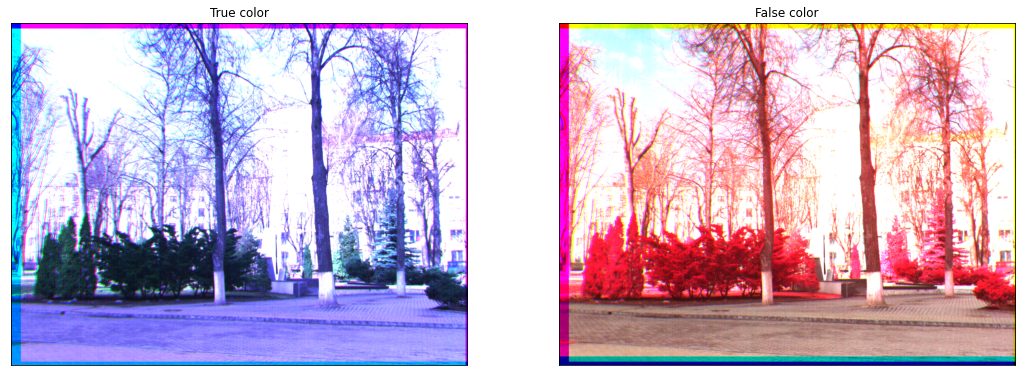

In [49]:
plt.figure(figsize = (18, 10))
plt.subplot(1,2,1)
plt.title('True color')
rgb_stack_transform = np.stack((red_shift,  green_shift, blue_calibrated), axis = 2)
plt.imshow(rgb_stack_transform)
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
plt.title('False color')
nir_stack_transform = np.stack((nir_shift, red_shift,  green_shift), axis = 2)
plt.imshow(nir_stack_transform)
plt.xticks([])
plt.yticks([])

plt.show()

## NDVI

In [50]:
def normalized_index(band1, band2):
    index = (band1 - band2)/(band1 + band2)
    index[np.isneginf(index)] = 1
    index[index>1] = 1
    index[np.isnan(index)] = 1
    return (index)

In [51]:
ndvi = normalized_index(nir_shift, red_shift)

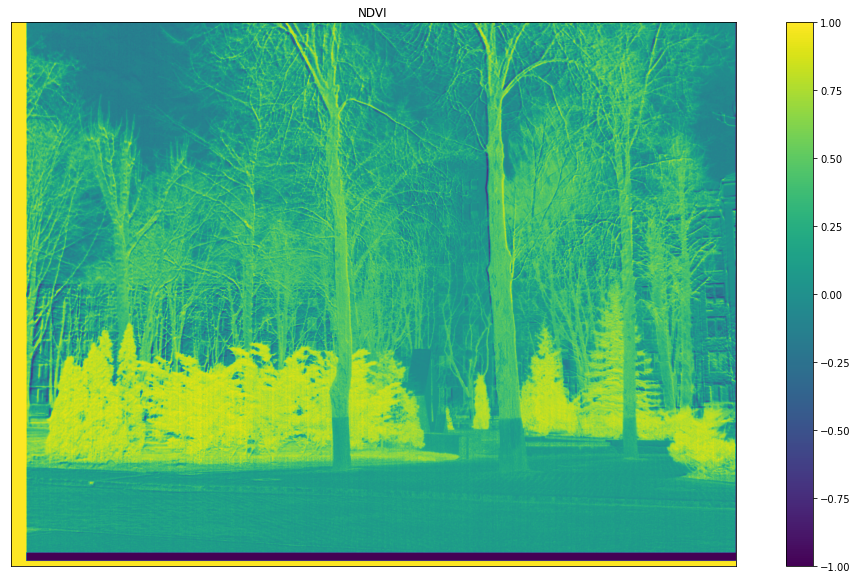

In [52]:
plt.figure(figsize = (18, 10))
plt.title('NDVI')
plt.imshow(normalized_index(nir_shift, red_shift), vmin = -1, vmax = 1)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()